# Classifier using LSTM layers

## 1. Importing Libraries

In [39]:
import torch

import numpy as np
import pandas as pd

data_folder = '../data/ctrpts'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2. Data Preprocessing

### 2.1. Loading the data

In [40]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/ctrlpts/calculator_ctrlpt.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/ctrlpts/camera_ctrlpt.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/ctrlpts/cell_phone_ctrlpt.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [41]:
calculator_data.get('train').shape, camera_data.get('train').shape, cellphone_data.get('train').shape

((17928,), (17938,), (17976,))

In [42]:
from sklearn.model_selection import train_test_split

# Limiting data to 5000 points per class
def slice_data(data):
    # Assuming that the data arrays in each 'train', 'test', 'valid' are already shuffled
    sliced = []
    for key in ['train', 'test', 'valid']:
        # Slicing each segment
        sliced.append(data[key])
    # Concatenate slices from train, test, valid
    return np.concatenate(sliced)

# Slicing the data
calculator_sliced = slice_data(calculator_data)[:5000]
camera_sliced = slice_data(camera_data)[:5000]
cellphone_sliced = slice_data(cellphone_data)[:5000]

# Concatenate all sliced data
def concatenate_data(*datasets):
    features = []
    labels = []
    for data, cid in zip(datasets, class_id.values()):
        features.append(data)
        labels.extend([cid] * len(data))
    features = np.concatenate(features)
    labels = np.array(labels)
    return features, labels

features, labels = concatenate_data(calculator_sliced, camera_sliced, cellphone_sliced)

# Split into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [43]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12000,), (12000,), (3000,), (3000,))

In [44]:
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from scipy.interpolate import interp1d

def standardize_lengths(data, target_length=29):
    standardized_data = []

    for sequence in data:
        # Current length of the sequence
        current_length = sequence.shape[0]
        
        # Create an array of indices based on current length
        current_indices = np.linspace(0, 1, current_length)
        
        # Target indices for interpolation
        target_indices = np.linspace(0, 1, target_length)
        
        # Initialize interpolated sequence
        interpolated_sequence = np.zeros((target_length, sequence.shape[1]))
        
        # Interpolate each channel
        for i in range(sequence.shape[1]):
            # Interpolate the i-th channel
            interpolator = interp1d(current_indices, sequence[:, i], kind='linear')
            interpolated_sequence[:, i] = interpolator(target_indices)
        
        # Append the interpolated sequence to the standardized data list
        standardized_data.append(interpolated_sequence)

    return np.array(standardized_data)

# Apply standardization on X_train and X_test
X_train_standardized = standardize_lengths(X_train)
X_test_standardized = standardize_lengths(X_test)

def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train_standardized, X_test_standardized, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [45]:
print(len(train_loader))
print(len(test_loader))

188
47


In [46]:
X_train_standardized.shape, X_test_standardized.shape

((12000, 29, 3), (3000, 29, 3))

## 3. Model Building

### 3.1. Quantum Layer

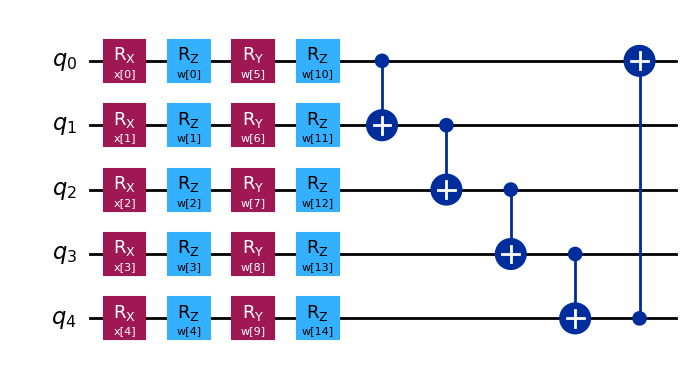

In [47]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)

    for i in range(n):
        circuit.rx(features[i], i)

    return circuit

def quantum_ansatz(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)

    for i in range(n):
        circuit.rz(weights[i], i)

    for i in range(n):
        circuit.ry(weights[n+i], i)

    for i in range(n):
        circuit.rz(weights[2*n+i], i)

    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)

    return circuit

def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)

    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        #self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        #self.bn1 = nn.BatchNorm1d(num_features=16)
        #self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        #self.bn2 = nn.BatchNorm1d(num_features=32)
        #self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        #self.bn3 = nn.BatchNorm1d(num_features=64)
        #self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        #self.bn4 = nn.BatchNorm1d(num_features=128)
        #self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(14, 14)
        self.fc2 = nn.Linear(14, 14)

        # Quantum layer
        self.fc3 = nn.Linear(14, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        #x = x.permute(0, 2, 1)

        # Convolutional layers
        #x = F.relu(self.bn1(self.conv1(x)))
        #x = self.pool1(x)
        
        #x = F.relu(self.bn2(self.conv2(x)))
        #x = self.pool2(x)
        
        #x = F.relu(self.bn3(self.conv3(x)))
        #x = self.pool3(x)
        
        #x = F.relu(self.bn4(self.conv4(x)))
        #x = self.pool4(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [49]:
checkpoint_filepath = 'models/2edition_quantum_lstm/best_model_weights_3classes_ctrlpts.pth'

In [50]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(50):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 188/188 [23:17<00:00,  7.44s/it]


Epoch 1, Accuracy: 0.3303333333333333, Loss: 1.0870001924798844, Validation Accuracy: 0.3456666666666667, Validation Loss: 1.0609920024871826


100%|██████████| 188/188 [23:04<00:00,  7.36s/it]


Epoch 2, Accuracy: 0.33025, Loss: 1.0409779237939956, Validation Accuracy: 0.3456666666666667, Validation Loss: 1.0195567607879639


100%|██████████| 188/188 [22:55<00:00,  7.31s/it]


Epoch 3, Accuracy: 0.33025, Loss: 1.003698508473153, Validation Accuracy: 0.3456666666666667, Validation Loss: 0.9953712821006775


100%|██████████| 188/188 [23:23<00:00,  7.46s/it]


Epoch 4, Accuracy: 0.33025, Loss: 0.9799758205388455, Validation Accuracy: 0.3456666666666667, Validation Loss: 0.9828709363937378


100%|██████████| 188/188 [23:19<00:00,  7.44s/it]


Epoch 5, Accuracy: 0.38425, Loss: 0.9583720155852906, Validation Accuracy: 0.519, Validation Loss: 0.9634131789207458


100%|██████████| 188/188 [22:52<00:00,  7.30s/it]


Epoch 6, Accuracy: 0.54425, Loss: 0.9341048500005235, Validation Accuracy: 0.5213333333333333, Validation Loss: 0.9482519626617432


100%|██████████| 188/188 [22:34<00:00,  7.21s/it]


Epoch 7, Accuracy: 0.5465, Loss: 0.913948451902004, Validation Accuracy: 0.5193333333333333, Validation Loss: 0.924786388874054


100%|██████████| 188/188 [24:00<00:00,  7.66s/it]


Epoch 8, Accuracy: 0.5386666666666666, Loss: 0.8759436318848995, Validation Accuracy: 0.508, Validation Loss: 0.8961911201477051


100%|██████████| 188/188 [23:54<00:00,  7.63s/it]


Epoch 9, Accuracy: 0.5396666666666666, Loss: 0.8396308216008734, Validation Accuracy: 0.504, Validation Loss: 0.8834222555160522


100%|██████████| 188/188 [23:21<00:00,  7.46s/it]


Epoch 10, Accuracy: 0.5428333333333333, Loss: 0.8177404980710212, Validation Accuracy: 0.5093333333333333, Validation Loss: 0.8772150874137878


100%|██████████| 188/188 [23:18<00:00,  7.44s/it]


Epoch 11, Accuracy: 0.54425, Loss: 0.7975594674019103, Validation Accuracy: 0.49766666666666665, Validation Loss: 0.8742719888687134


100%|██████████| 188/188 [23:14<00:00,  7.42s/it]


Epoch 12, Accuracy: 0.6026666666666667, Loss: 0.7685072441050347, Validation Accuracy: 0.7253333333333334, Validation Loss: 0.7939538359642029


100%|██████████| 188/188 [23:18<00:00,  7.44s/it]


Epoch 13, Accuracy: 0.80625, Loss: 0.6302137078439936, Validation Accuracy: 0.7336666666666667, Validation Loss: 0.7266911268234253


100%|██████████| 188/188 [23:14<00:00,  7.42s/it]


Epoch 14, Accuracy: 0.8145833333333333, Loss: 0.5718491587867128, Validation Accuracy: 0.7316666666666667, Validation Loss: 0.7111256122589111


100%|██████████| 188/188 [23:14<00:00,  7.42s/it]


Epoch 15, Accuracy: 0.8211666666666667, Loss: 0.5419930492309813, Validation Accuracy: 0.7393333333333333, Validation Loss: 0.688818097114563


100%|██████████| 188/188 [23:27<00:00,  7.49s/it]


Epoch 16, Accuracy: 0.82925, Loss: 0.512402206976363, Validation Accuracy: 0.7336666666666667, Validation Loss: 0.6800089478492737


100%|██████████| 188/188 [23:27<00:00,  7.49s/it]


Epoch 17, Accuracy: 0.83675, Loss: 0.49550503349684655, Validation Accuracy: 0.757, Validation Loss: 0.6679573059082031


100%|██████████| 188/188 [23:34<00:00,  7.52s/it]


Epoch 18, Accuracy: 0.8476666666666667, Loss: 0.4710858310473726, Validation Accuracy: 0.751, Validation Loss: 0.6710739135742188


100%|██████████| 188/188 [23:37<00:00,  7.54s/it]


Epoch 19, Accuracy: 0.8539166666666667, Loss: 0.4500807249482642, Validation Accuracy: 0.7546666666666667, Validation Loss: 0.6684553027153015


100%|██████████| 188/188 [23:23<00:00,  7.47s/it]


Epoch 20, Accuracy: 0.8555, Loss: 0.44202882003911, Validation Accuracy: 0.7526666666666667, Validation Loss: 0.6585540771484375


100%|██████████| 188/188 [23:54<00:00,  7.63s/it]


Epoch 21, Accuracy: 0.8648333333333333, Loss: 0.4212581295757852, Validation Accuracy: 0.7556666666666667, Validation Loss: 0.6630986332893372


100%|██████████| 188/188 [23:26<00:00,  7.48s/it]


Epoch 22, Accuracy: 0.8713333333333333, Loss: 0.40493527015155933, Validation Accuracy: 0.75, Validation Loss: 0.6750238537788391


100%|██████████| 188/188 [23:22<00:00,  7.46s/it]


Epoch 23, Accuracy: 0.8713333333333333, Loss: 0.40297424167077595, Validation Accuracy: 0.7473333333333333, Validation Loss: 0.6732047200202942


100%|██████████| 188/188 [23:19<00:00,  7.44s/it]


Epoch 24, Accuracy: 0.8765833333333334, Loss: 0.3930826946458918, Validation Accuracy: 0.7506666666666667, Validation Loss: 0.6814671754837036


100%|██████████| 188/188 [23:31<00:00,  7.51s/it]


Epoch 25, Accuracy: 0.8758333333333334, Loss: 0.3878754938536502, Validation Accuracy: 0.756, Validation Loss: 0.6759048700332642


100%|██████████| 188/188 [23:38<00:00,  7.54s/it]


Epoch 26, Accuracy: 0.8850833333333333, Loss: 0.37008665486219083, Validation Accuracy: 0.7556666666666667, Validation Loss: 0.681465208530426


100%|██████████| 188/188 [23:12<00:00,  7.41s/it]


Epoch 27, Accuracy: 0.8884166666666666, Loss: 0.36391404437574937, Validation Accuracy: 0.7536666666666667, Validation Loss: 0.6864519119262695


100%|██████████| 188/188 [22:51<00:00,  7.30s/it]


Epoch 28, Accuracy: 0.8868333333333334, Loss: 0.3627366701022108, Validation Accuracy: 0.7566666666666667, Validation Loss: 0.6821683049201965


100%|██████████| 188/188 [23:01<00:00,  7.35s/it]


Epoch 29, Accuracy: 0.8891666666666667, Loss: 0.3552496112248999, Validation Accuracy: 0.7466666666666667, Validation Loss: 0.712105929851532


100%|██████████| 188/188 [23:36<00:00,  7.54s/it]


Epoch 30, Accuracy: 0.89175, Loss: 0.34906198916600106, Validation Accuracy: 0.759, Validation Loss: 0.6837190389633179


100%|██████████| 188/188 [23:23<00:00,  7.46s/it]


Epoch 31, Accuracy: 0.8916666666666667, Loss: 0.3431378805098381, Validation Accuracy: 0.7586666666666667, Validation Loss: 0.6909518837928772


100%|██████████| 188/188 [24:07<00:00,  7.70s/it]


Epoch 32, Accuracy: 0.891, Loss: 0.34354550276506457, Validation Accuracy: 0.7476666666666667, Validation Loss: 0.7083292007446289


100%|██████████| 188/188 [23:47<00:00,  7.59s/it]


Epoch 33, Accuracy: 0.8955, Loss: 0.3351403625404581, Validation Accuracy: 0.7573333333333333, Validation Loss: 0.7056659460067749


100%|██████████| 188/188 [23:02<00:00,  7.36s/it]


Epoch 34, Accuracy: 0.8998333333333334, Loss: 0.3232198090470852, Validation Accuracy: 0.759, Validation Loss: 0.7175757884979248


100%|██████████| 188/188 [23:03<00:00,  7.36s/it]


Epoch 35, Accuracy: 0.902, Loss: 0.3215020637800719, Validation Accuracy: 0.749, Validation Loss: 0.7205247282981873


100%|██████████| 188/188 [23:03<00:00,  7.36s/it]


Epoch 36, Accuracy: 0.9034166666666666, Loss: 0.3162678356500382, Validation Accuracy: 0.7506666666666667, Validation Loss: 0.7286136746406555


100%|██████████| 188/188 [23:09<00:00,  7.39s/it]


Epoch 37, Accuracy: 0.9031666666666667, Loss: 0.3156145417547606, Validation Accuracy: 0.7613333333333333, Validation Loss: 0.6890755891799927


100%|██████████| 188/188 [23:04<00:00,  7.37s/it]


Epoch 38, Accuracy: 0.9079166666666667, Loss: 0.30318147419614994, Validation Accuracy: 0.7603333333333333, Validation Loss: 0.7145625948905945


100%|██████████| 188/188 [23:05<00:00,  7.37s/it]


Epoch 39, Accuracy: 0.9031666666666667, Loss: 0.3094292671439495, Validation Accuracy: 0.7603333333333333, Validation Loss: 0.7041499018669128


100%|██████████| 188/188 [23:06<00:00,  7.37s/it]


Epoch 40, Accuracy: 0.90975, Loss: 0.2996419538605086, Validation Accuracy: 0.764, Validation Loss: 0.6986867189407349


100%|██████████| 188/188 [23:05<00:00,  7.37s/it]


Epoch 41, Accuracy: 0.9125833333333333, Loss: 0.2876761296486601, Validation Accuracy: 0.7673333333333333, Validation Loss: 0.7088150978088379


100%|██████████| 188/188 [23:07<00:00,  7.38s/it]


Epoch 42, Accuracy: 0.914, Loss: 0.28331586195433395, Validation Accuracy: 0.7533333333333333, Validation Loss: 0.725570023059845


100%|██████████| 188/188 [23:06<00:00,  7.37s/it]


Epoch 43, Accuracy: 0.9101666666666667, Loss: 0.2886184969560263, Validation Accuracy: 0.7633333333333333, Validation Loss: 0.7240883708000183


100%|██████████| 188/188 [23:03<00:00,  7.36s/it]


Epoch 44, Accuracy: 0.9115833333333333, Loss: 0.28502215425226285, Validation Accuracy: 0.7596666666666667, Validation Loss: 0.7343873977661133


100%|██████████| 188/188 [23:06<00:00,  7.38s/it]


Epoch 45, Accuracy: 0.9148333333333334, Loss: 0.2768462985912536, Validation Accuracy: 0.7626666666666667, Validation Loss: 0.7275449633598328


100%|██████████| 188/188 [23:05<00:00,  7.37s/it]


Epoch 46, Accuracy: 0.9145833333333333, Loss: 0.27711174442888575, Validation Accuracy: 0.7663333333333333, Validation Loss: 0.7254805564880371


100%|██████████| 188/188 [22:57<00:00,  7.33s/it]


Epoch 47, Accuracy: 0.91625, Loss: 0.2743086836280975, Validation Accuracy: 0.767, Validation Loss: 0.7330825924873352


100%|██████████| 188/188 [23:01<00:00,  7.35s/it]


Epoch 48, Accuracy: 0.9135833333333333, Loss: 0.2761555713938272, Validation Accuracy: 0.7596666666666667, Validation Loss: 0.7381348609924316


100%|██████████| 188/188 [23:04<00:00,  7.36s/it]


Epoch 49, Accuracy: 0.9165833333333333, Loss: 0.2689962553534102, Validation Accuracy: 0.7606666666666667, Validation Loss: 0.7444018721580505


100%|██████████| 188/188 [22:59<00:00,  7.34s/it]


Epoch 50, Accuracy: 0.9185833333333333, Loss: 0.26135937342459853, Validation Accuracy: 0.7603333333333333, Validation Loss: 0.7666177153587341


## 5. Model Evaluation

In [52]:
val_loss_list = [acc.cpu().numpy() for acc in val_loss_list]

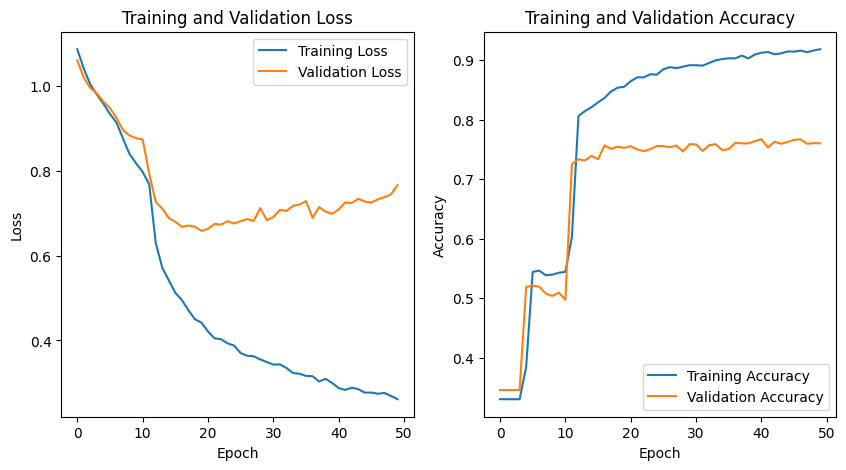

In [53]:
import matplotlib.pyplot as plt

def plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list):
    plt.figure(figsize=(10, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list)

In [ ]:
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)

In [ ]:
INDEX = 0

out = model.predict(X_test[:2500][INDEX])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])